---
---

### Comparing Classifiers

Given data that is related with direct marketing campaigns of a banking institution, we would like to compare the performance of four different classifiers (k-nearest neighbors, logistic regression, decision trees, and support vector machines). The data includes information regarding customer ages, jobs, marital status, etc. and whether the client will subscribe (yes/no) a bank term deposit (indicated by variable 'y').

---
---   

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay, auc, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [43]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [45]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [46]:
# Further investigate the data and the unique values for some of the fields
def printUniqueValues(df):
    object_columns = df.select_dtypes(include='object').columns
    for colname in object_columns:
        unique_values = df[colname].unique()
        print(f'{colname.upper()} unique values: {unique_values}')

printUniqueValues(df)

JOB unique values: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
MARITAL unique values: ['married' 'single' 'divorced' 'unknown']
EDUCATION unique values: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
DEFAULT unique values: ['no' 'unknown' 'yes']
HOUSING unique values: ['no' 'yes' 'unknown']
LOAN unique values: ['no' 'yes' 'unknown']
CONTACT unique values: ['telephone' 'cellular']
MONTH unique values: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
DAY_OF_WEEK unique values: ['mon' 'tue' 'wed' 'thu' 'fri']
POUTCOME unique values: ['nonexistent' 'failure' 'success']
Y unique values: ['no' 'yes']


In [47]:
# I notice there are some value options of `unknown`. This is similar to N/A or null so let's see if we can drop those as well
df = df.replace('unknown', np.nan).dropna()

# We will also not use some of these columns:
columns_to_drop = ['contact', 'month', 'day_of_week']
df = df.drop(columns=columns_to_drop)

df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 30488 entries, 0 to 41187
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   duration        30488 non-null  int64  
 8   campaign        30488 non-null  int64  
 9   pdays           30488 non-null  int64  
 10  previous        30488 non-null  int64  
 11  poutcome        30488 non-null  object 
 12  emp.var.rate    30488 non-null  float64
 13  cons.price.idx  30488 non-null  float64
 14  cons.conf.idx   30488 non-null  float64
 15  euribor3m       30488 non-null  float64
 16  nr.employed     30488 non-null  float64
 17  y               30488 non-null  obje

(30488, 18)

In [48]:
# Now let's see what the unique values are again after removing `unknown`
printUniqueValues(df)

JOB unique values: ['housemaid' 'services' 'admin.' 'technician' 'blue-collar' 'unemployed'
 'retired' 'entrepreneur' 'management' 'student' 'self-employed']
MARITAL unique values: ['married' 'single' 'divorced']
EDUCATION unique values: ['basic.4y' 'high.school' 'basic.6y' 'professional.course' 'basic.9y'
 'university.degree' 'illiterate']
DEFAULT unique values: ['no' 'yes']
HOUSING unique values: ['no' 'yes']
LOAN unique values: ['no' 'yes']
POUTCOME unique values: ['nonexistent' 'failure' 'success']
Y unique values: ['no' 'yes']


---
#### Briefly visualize the data and how it is spread

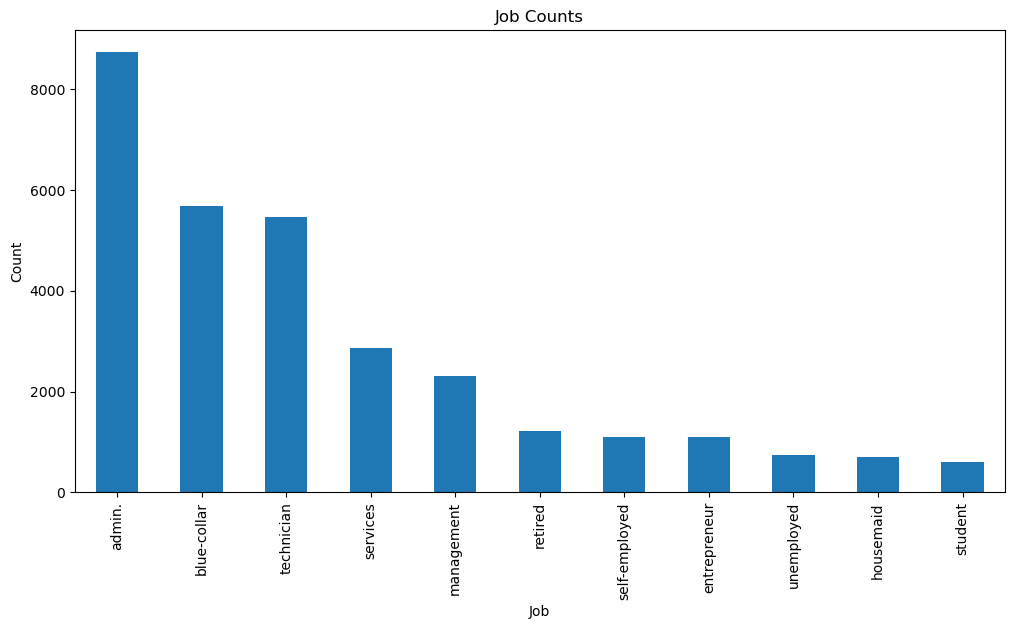

In [49]:
plt.figure(figsize=(12, 6))
df['job'].value_counts().plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Job')
plt.ylabel('Count')
plt.title('Job Counts')
plt.show()

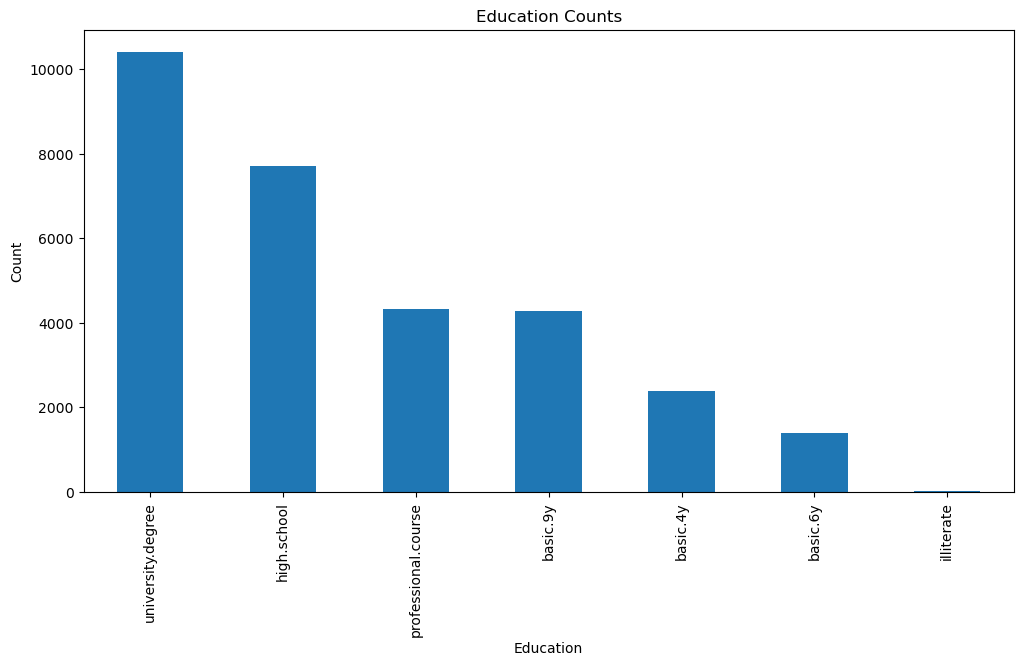

In [50]:
plt.figure(figsize=(12, 6))
df['education'].value_counts().plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Education Counts')
plt.show()

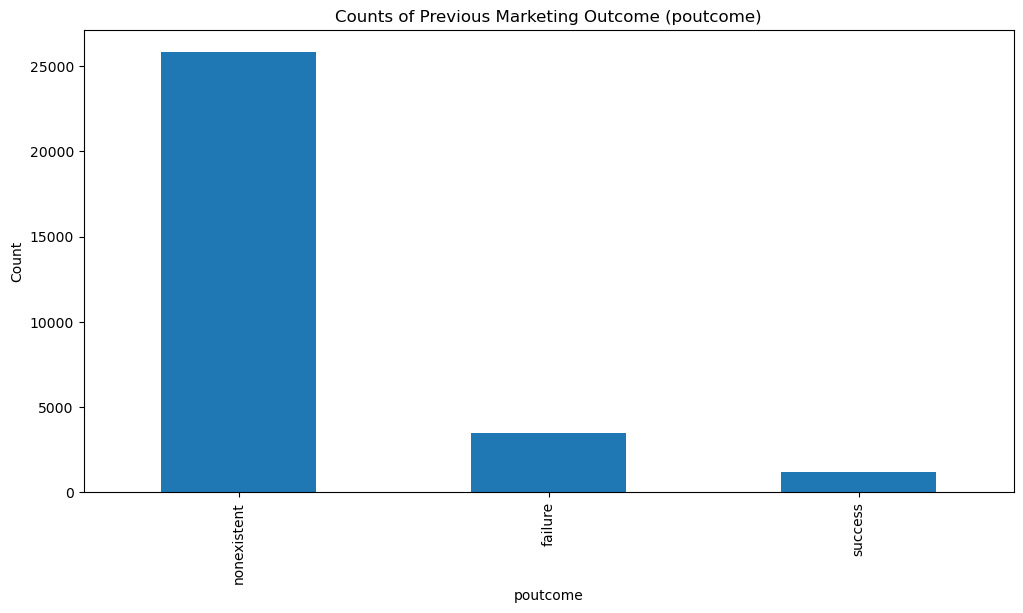

In [51]:
plt.figure(figsize=(12, 6))
df['poutcome'].value_counts().plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('poutcome')
plt.ylabel('Count')
plt.title('Counts of Previous Marketing Outcome (poutcome)')
plt.show()

Text(0.5, 1.05, 'Pairplot of Features')

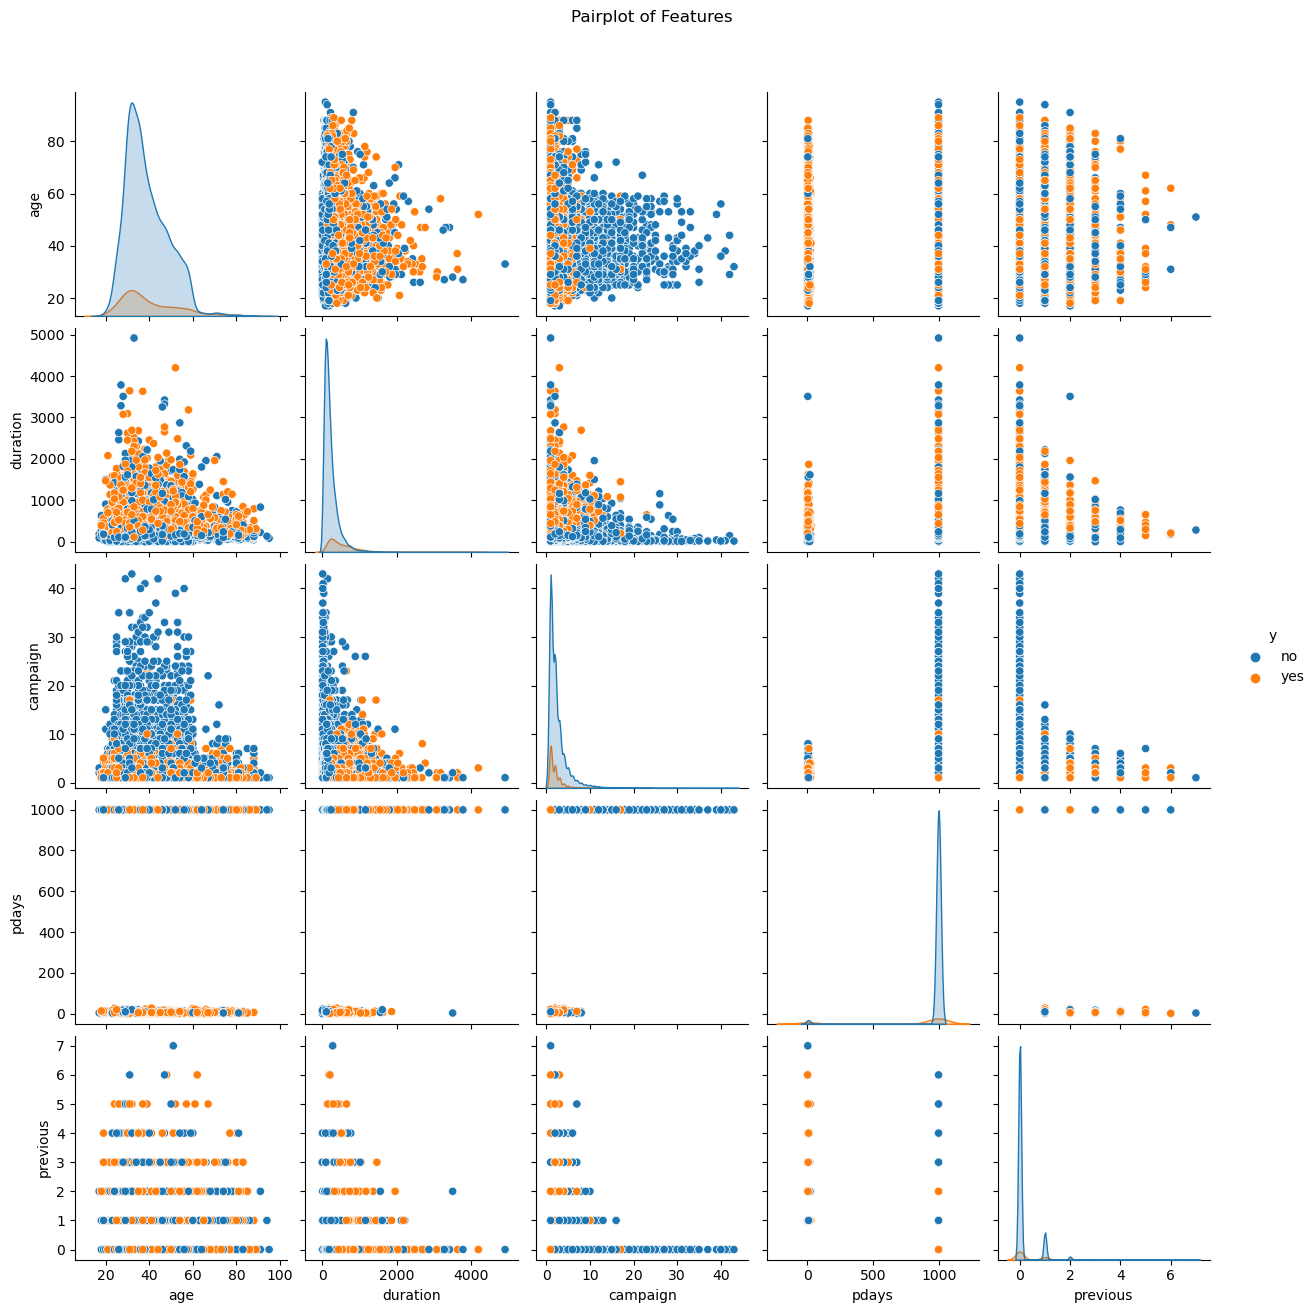

In [72]:
# Visualizing some of the data using a pairplot:
sns.pairplot(data = df.select_dtypes(include=['int64']).join(df['y']), hue = 'y')
plt.suptitle('Pairplot of Features', y=1.05)

Baseline: y
no     0.873426
yes    0.126574
Name: proportion, dtype: float64


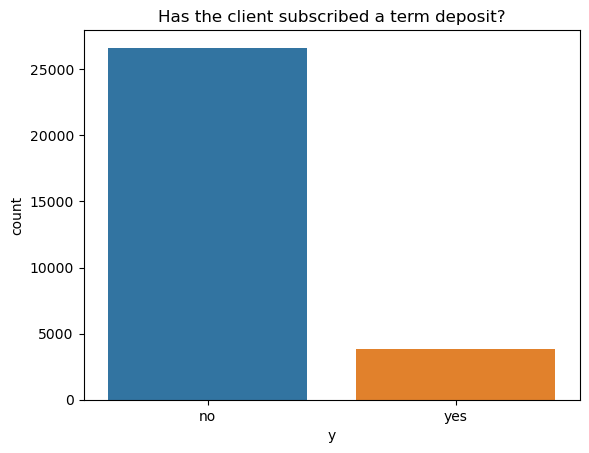

In [53]:
# Let's view the target 'y' using a seaborn countplot. How many clients have subscribed a term deposit?
sns.countplot(data=df, x = 'y')
plt.title('Has the client subscribed a term deposit?');

# Determine our baseline for the model
baseline = df['y'].value_counts(normalize = True)
print(f'Baseline: {baseline}')

---
---

#### KNN

---
---   

In [54]:
# Set X, Y, and train/test sets
X = df.drop(['y'], axis = 1);
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=34)

In [55]:
# Create a column transformer and build a pipeline with the transformer
onehots = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']

transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), onehots),
                                     remainder = StandardScaler())

# Pipe default and pipe with n_neighbors = 10
knn_pipe = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)

preds = knn_pipe.predict(X_test)

In [56]:
# Determine best k:
params = {'knn__n_neighbors': list(range(1, 50, 2))}
knn_grid = GridSearchCV(knn_pipe, param_grid=params)
knn_grid.fit(X_train, y_train)
best_k = list(knn_grid.best_params_.values())[0]
print(f'Best k: {best_k}')

Best k: 43


In [57]:
# Create more Pipelines with n_neighbors 10 and of best_k, 43:
knn_pipe_10 = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier(n_neighbors = 10))])
knn_pipe_10.fit(X_train, y_train)

knn_pipe_best_k = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier(n_neighbors = 43))])
knn_pipe_best_k.fit(X_train, y_train)

knn_pipe_1 = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier(n_neighbors = 1))])
knn_pipe_1.fit(X_train, y_train)

preds_10 = knn_pipe_10.predict(X_test)
preds_best_k = knn_pipe_best_k.predict(X_test)
preds_1 = knn_pipe_1.predict(X_test)

print(f'preds: {preds}; preds_10: {preds_10}; preds_best_k: {preds_best_k}; preds_1: {preds_1}')

preds: ['no' 'no' 'no' ... 'no' 'no' 'no']; preds_10: ['no' 'no' 'no' ... 'no' 'no' 'no']; preds_best_k: ['no' 'no' 'no' ... 'no' 'no' 'no']; preds_1: ['no' 'no' 'no' ... 'no' 'no' 'no']


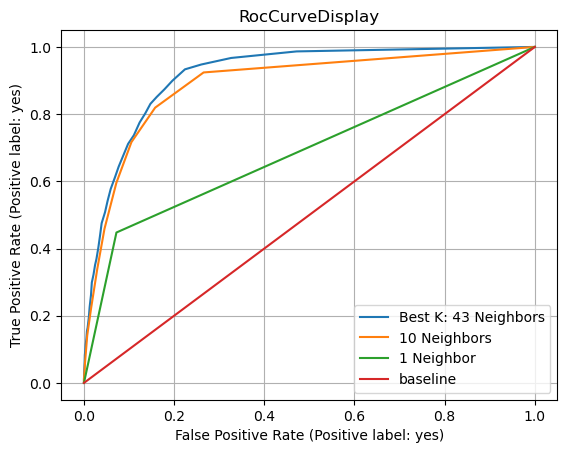

In [58]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(knn_pipe_best_k, X_test, y_test, pos_label = 'yes', ax = ax, label = 'Best K: 43 Neighbors')
RocCurveDisplay.from_estimator(knn_pipe_10, X_test, y_test, pos_label = 'yes', ax = ax, label = '10 Neighbors')
RocCurveDisplay.from_estimator(knn_pipe_1, X_test, y_test, ax = ax, label = '1 Neighbor')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('RocCurveDisplay')
plt.legend();

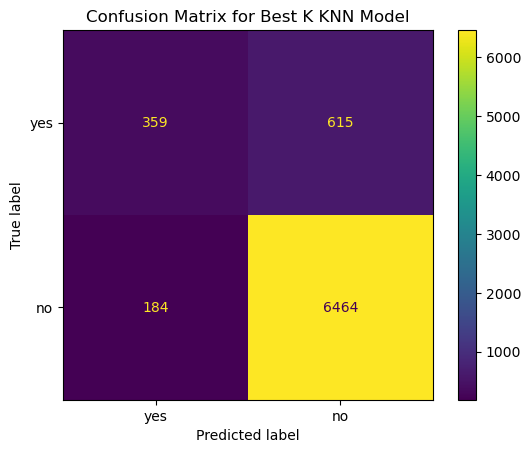

In [59]:
confusion_matr = confusion_matrix(y_test, preds_best_k, labels=['yes', 'no'])
knn_confusion = ConfusionMatrixDisplay(confusion_matrix=confusion_matr, display_labels=['yes', 'no' ])
knn_confusion.plot()
plt.title('Confusion Matrix for Best K KNN Model')
plt.show()

---
---

#### Logistic Regression

---
---   

In [60]:
# I've already set the dataframe and created a transformer for the KNN, let's start with creating a feature extractor:
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))

In [61]:
# Create the logistic regression pipe
lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])
lgr_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'poutcome'])])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])

Text(0.5, 1.0, 'Logistic Regression RocCurve')

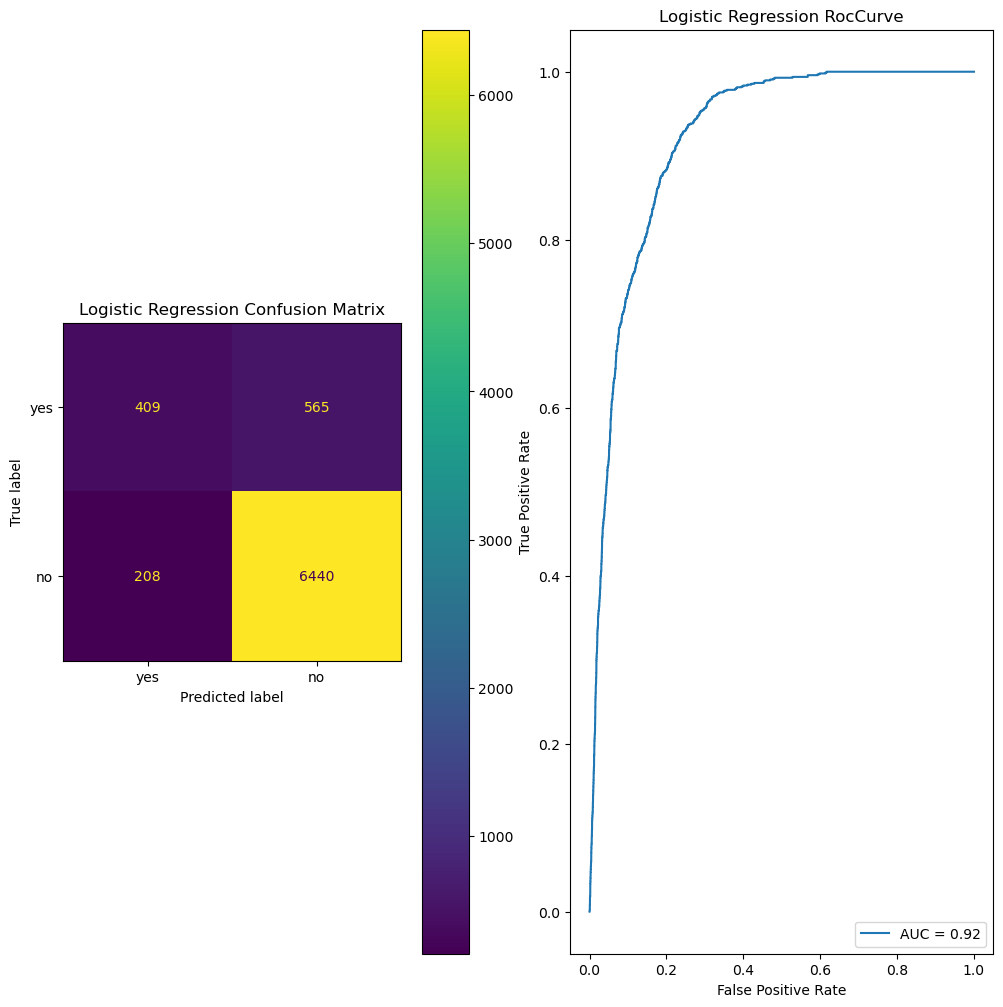

In [62]:
# Set figures to view the confusion matrix and RocCurve
lgr_preds = lgr_pipe.predict(X_test)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

# Confusion Matrix
lgr_conf_matrix = confusion_matrix(y_test, lgr_preds, labels=['yes', 'no'])
lgr_conf_matrix_disp = ConfusionMatrixDisplay(lgr_conf_matrix, display_labels=['yes', 'no' ])
lgr_conf_matrix_disp.plot(ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')

# ROC Curve
lgr_y_score = lgr_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, lgr_y_score, pos_label='yes')
lgr_roc_auc_value = auc(fpr, tpr)

lgr_roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=lgr_roc_auc_value)
lgr_roc_display.plot(ax=ax[1])
plt.title('Logistic Regression RocCurve')

---
---

#### Decision Trees

---
---   

In [63]:
# Build a pipeline to transform the data and create a decision tree classifier:
dtree_params = {
    'min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
    'max_depth': [2, 5, 10],
    'min_samples_split': [0.1, 0.2, 0.05]
}

dtree_pipe = Pipeline([
    ('transform', transformer),
    ('tree', GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=dtree_params))
])

dtree = dtree_pipe.fit(X_train, y_train)

# Set best tree
dtree_best_params = dtree.named_steps['tree'].best_params_
print(f'Best parameters of tree: {dtree_best_params}')
dtree_best = dtree.named_steps['tree'].best_estimator_
X_test_transformed = dtree_pipe.named_steps['transform'].transform(X_test)

Best parameters of tree: {'max_depth': 2, 'min_impurity_decrease': 0.01, 'min_samples_split': 0.1}


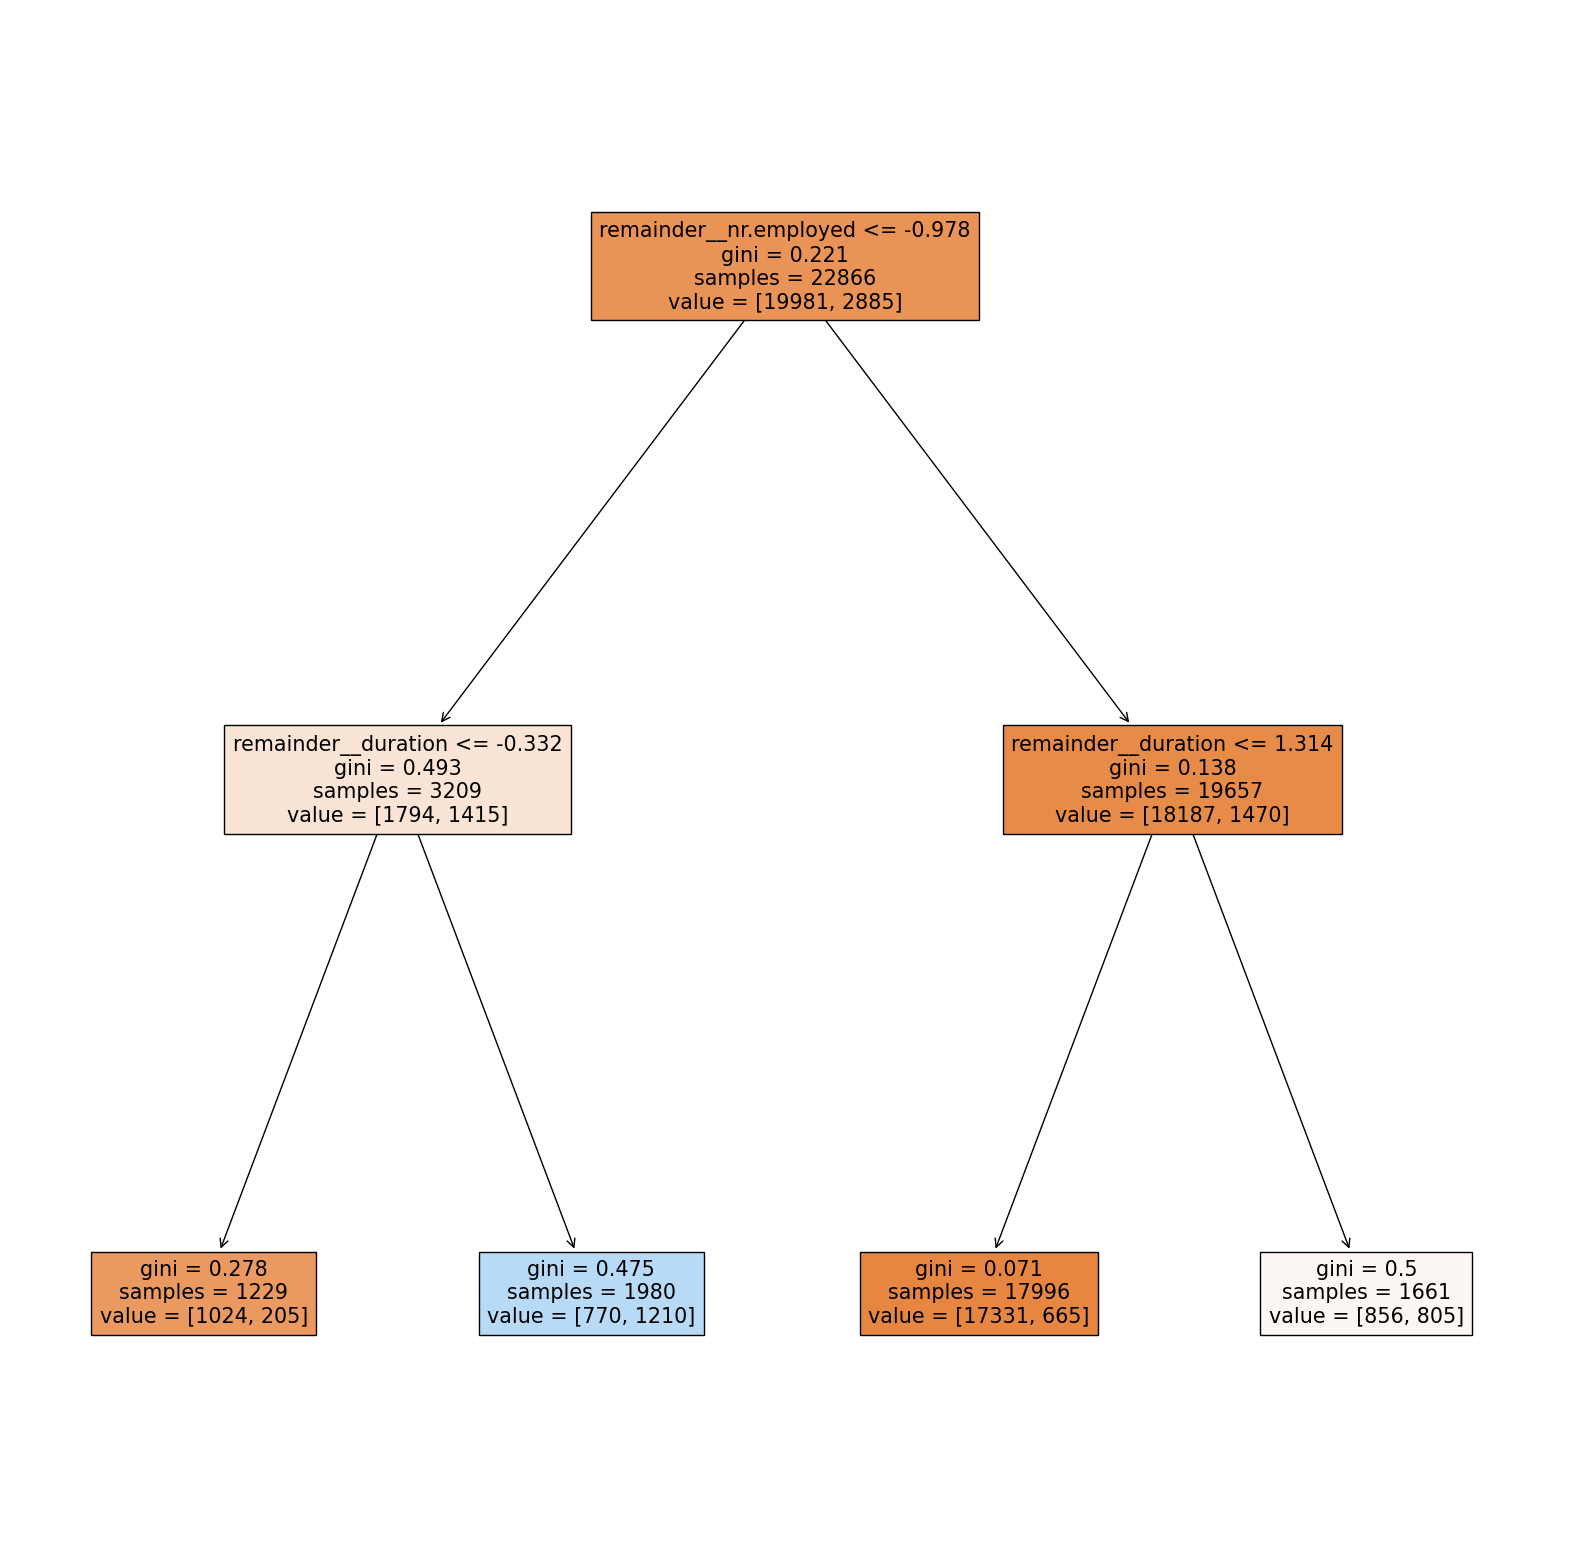

In [64]:
# Visualize tree
dtree_ft_names = dtree_pipe.named_steps['transform'].get_feature_names_out()
fig, ax = plt.subplots(figsize=(20, 20))
dtree_viz = plot_tree(dtree_best, feature_names=dtree_ft_names, filled=True)

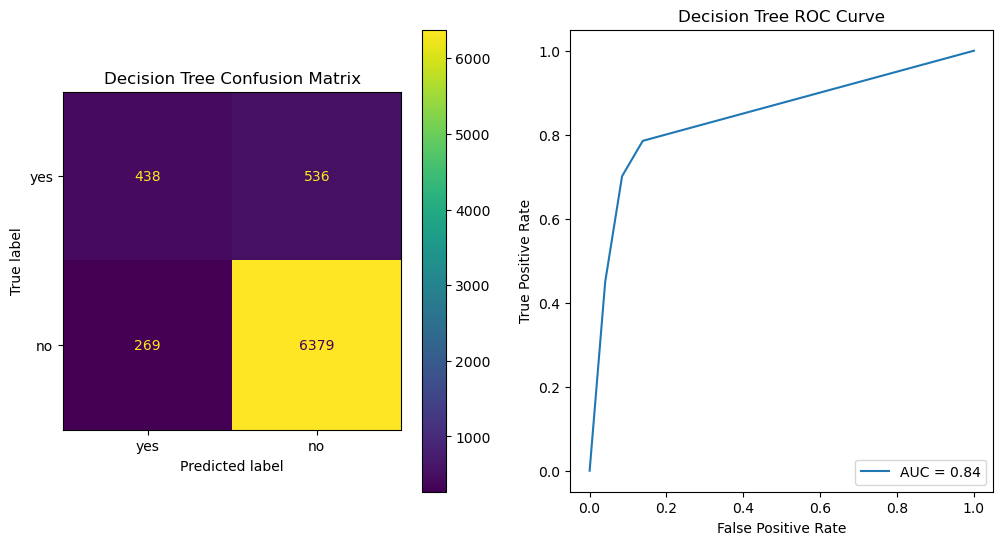

In [65]:
# Set predictions from the best decision tree
dtree_preds = dtree_best.predict(X_test_transformed)

# Set figure sizing for the plots
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

# Confusion Matrix
dtree_conf_matrix = confusion_matrix(y_test, dtree_preds, labels=['yes', 'no'])
dtree_conf_matrix_disp = ConfusionMatrixDisplay(dtree_conf_matrix, display_labels=['yes', 'no'])
dtree_conf_matrix_disp.plot(ax=ax[0])
ax[0].set_title('Decision Tree Confusion Matrix')

# ROC Curve
dtree_y_score = dtree_best.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, dtree_y_score, pos_label='yes')
dtree_roc_auc_value = auc(fpr, tpr)

dtree_roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=dtree_roc_auc_value)
dtree_roc_display.plot(ax=ax[1])
ax[1].set_title('Decision Tree ROC Curve')

plt.show()

---
---

#### Support Vector Machines

---
---   

In [66]:
svc_pipe = Pipeline([
    ('transform', transformer),
    ('svc', SVC(random_state=42))
])
svc_pipe.fit(X_train, y_train)
svc_preds = svc_pipe.predict(X_test)

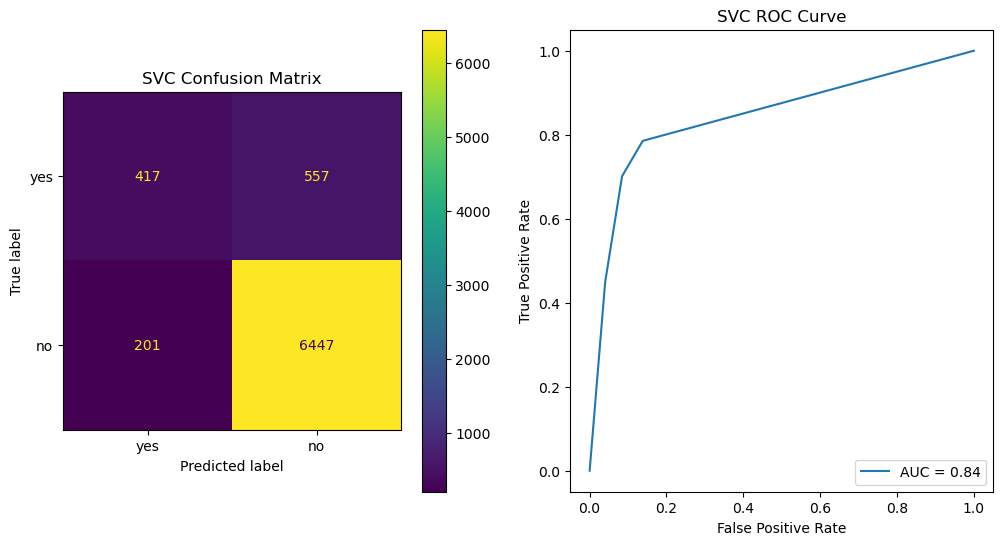

In [67]:
# Set SVC predictions
svc_preds = svc_pipe.predict(X_test)

# Set figure sizing for the plots
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

# Confusion Matrix
svc_conf_matrix = confusion_matrix(y_test, svc_preds, labels=['yes', 'no'])
svc_conf_matrix_disp = ConfusionMatrixDisplay(svc_conf_matrix, display_labels=['yes', 'no'])
svc_conf_matrix_disp.plot(ax=ax[0])
ax[0].set_title('SVC Confusion Matrix')

# ROC Curve
svc_y_score = dtree_best.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, svc_y_score, pos_label='yes')
svc_roc_auc_value = auc(fpr, tpr)

svc_roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=svc_roc_auc_value)
svc_roc_display.plot(ax=ax[1])
ax[1].set_title('SVC ROC Curve')

plt.show()

---
---

#### Findings

---
---   

In [68]:
# Create these two functions to set the train and test acc scores
def returnTrainAcc(pipe):
    return pipe.score(X_train, y_train)

def returnTestAcc(pipe):
    return pipe.score(X_test, y_test)

In [69]:
# Set the variables for the train and test scores across all the classifiers
knn_train_acc = returnTrainAcc(knn_pipe_best_k)
knn_test_acc = returnTestAcc(knn_pipe_best_k)

lgr_train_acc = returnTrainAcc(lgr_pipe)
lgr_test_acc = returnTestAcc(lgr_pipe)

dtree_train_acc = returnTrainAcc(dtree)
dtree_test_acc = returnTestAcc(dtree)

svc_train_acc = returnTrainAcc(svc_pipe)
svc_test_acc = returnTestAcc(svc_pipe)

In [70]:
# View the scores in a new dataframe
acc_dict = {'model': ['KNN', 'Logistic Regression', 'Decision Tree', 'SVC'],
           'train score': [knn_train_acc, lgr_train_acc, dtree_train_acc, svc_train_acc],
           'test score': [knn_test_acc, lgr_test_acc, dtree_test_acc, svc_test_acc]}

acc_df = pd.DataFrame(acc_dict).set_index('model')
acc_df

,train score,test score
model,,
KNN,0.898364,0.895172
Logistic Regression,0.898015,0.898583
Decision Tree,0.893073,0.894385
SVC,0.909648,0.900551


All classifiers seemed to have performed pretty well. From this new dataframe we are able to compare the scores on both the train and test sets easily. SVC performs just slightly above the other classifiers with a train score of 0.909 and test score of 0.900. The SVC has the highest accuracy of the models we tested.

However, SVC did take a longer time to compute and with more or larger data we may find the other classifiers to be better suited while delivering very similar results in regards to overall accuracy.